# Lab 4

## Author: Yakovlev Konsatntin

### Description:
Build multiple (not less than 10) 1-layer neural networks for a dataset using bagging. Make a weighted ensemble of the models. Train ensemble weights in different regimes:

* Using Softmax
* Using Gumbel-softmax with lowering temperature

Visualize the performance of the ensembler from the optimization iteration. Visualize the weights of the ensemble with dependence on the optimization iteration.


### Theory:

Given a model $f: \mathbb{R}^n \to \Delta^{C - 1}$, where $C$ is a number of classes.
Given also a training and validation dataset $D_\text{train}, D_\text{val}$ of pairs $(x, y)$,
a loss function $\ell(x, y)$ and ensemble model $F(x, \gamma) = \sum_{i=1}^n f_i(x)\gamma_i$.


We consider two optimization problem satements: __Softmax__ and __Gumbel-Softmax__


__Softmax__

We formulate an ensemble weights search problem with BAGGING as follows:

$$\gamma^* = \arg\min_{\gamma}\sum_{(x, y) \in D_\text{val}}\ell(F(x, \gamma), y)$$

$$s.t. \quad f_i^* = \arg\min_{f_i}\sum_{(x, y) \in BOOTSTRAP(D_\text{train})}\ell(f_i(x), y),$$

where BOOSTRAP takes a dataset and outputs its subsample of the same size with replacements. In practice,
we parametrize $\gamma = softmax(\alpha)$.

__Gumbel-Softmax__

We formulate a degenerate ensemble search with BAGGING as follows:

$$\gamma^* = \arg\min_{\gamma}\mathbb{E}_{i \sim Cat(\gamma)}\sum_{(x, y) \in D_\text{val}}\ell(F(x, \gamma), y)$$

$$s.t. \quad f_i^* = \arg\min_{f_i}\sum_{(x, y) \in BOOTSTRAP(D_\text{train})}\ell(f_i(x), y).$$

Here we use Gumbel-Softmax trick to reparametrize $i \sim Cat(\gamma)$.

Note that in the second case we have a degenerated solution, i.e. $\gamma$ is a onne-hot vector, as we have
a munimization of a linear form on a simplex.

Inspired by this observation, we test the statement.

In [1]:
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

from sklearn.datasets import fetch_covtype

from dataclasses import dataclass
from tqdm import tqdm

import jax
import jax.numpy as jnp
import flax
from flax.training.train_state import TrainState
import flax.linen as nn
import optax

In [2]:
ds = fetch_covtype()
X, Y = ds['data'], ds['target']
print(X.shape, Y.shape, np.unique(Y))

# normalize
X = (X - X.mean(axis=0)[None]) / (X.std(axis=0)[None] + 1e-7)

n_classes = np.unique(Y).shape[0]
batch_size = 16
train_size = 200
val_size = 500
M = 15  # number of models

X_train = jnp.array(X[:train_size])
Y_train = jnp.array(Y[:train_size])

X_val, Y_val = jnp.array(X[train_size: train_size + val_size]), \
    jnp.array(Y[train_size: train_size + val_size])


(581012, 54) (581012,) [1 2 3 4 5 6 7]


In [3]:
class LogReg(nn.Module):
    n_out: int
    
    @nn.compact
    def __call__(self, x):
        return nn.Dense(self.n_out)(x)
    

In [4]:
@jax.jit
def loss_fn(outputs, targets):
    log_probs = nn.activation.log_softmax(outputs, axis=-1)
    return -(jnp.take_along_axis(log_probs, targets[..., None], axis=-1)).mean()

    
@jax.jit
def train_step(x_train, y_train, state):
    crit = lambda params: loss_fn(state.apply_fn(params, x_train), y_train)
    grad_fn = jax.value_and_grad(crit)
    loss, grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    return state, loss


@jax.jit
def validate(X_val, Y_val, state):
    return loss_fn(state.apply_fn(state.params, X_val), Y_val)


def train_and_val(X_train, Y_train, X_val, Y_val, state, epochs=100):
    report = {'train_loss': [], 'best_val_nll': 1e5}
    best_sd = state.params
    for epoch in range(epochs):
        # train
        for step in range(X_train.shape[0] // batch_size):
            x_train = X_train[step * batch_size: (step + 1) * batch_size]
            y_train = Y_train[step * batch_size: (step + 1) * batch_size]            
            state, train_loss = train_step(x_train, y_train, state)
            report['train_loss'].append(train_loss.item())
            
        # eval
        X_val = X_val
        Y_val = Y_val
        val_loss = validate(X_val, Y_val, state)
        if report['best_val_nll'] > val_loss:
            report['best_val_nll'] = val_loss
            best_sd = state.params
        # resample dataset
        ids = np.random.permutation(X_train.shape[0])
        X_train = X_train[ids]
        Y_train = Y_train[ids]
    
    return report, best_sd
    

In [5]:
np.random.seed(0)

report = {'best_val_nlls': [], 'train_losses': [], 'val_logits': []}

for m in tqdm(range(M)):    
    # bootstrap
    ids = np.random.choice(X_train.shape[0], size=(X_train.shape[0],))
    model = LogReg(n_classes)
    params = model.init({'params': jax.random.PRNGKey(m)}, X_train[:5])
    state = TrainState.create(apply_fn=model.apply, params=params, tx=optax.adam(1e-3))
    bs_report, best_sd = train_and_val(X_train[ids], Y_train[ids], X_val, Y_val, state)
    
    report['best_val_nlls'].append(bs_report['best_val_nll'])
    report['train_losses'].append(bs_report['train_loss'])
    report['val_logits'].append(model.apply(best_sd, X_val))
        
report['best_val_nlls']

100%|███████████████████████████████████████████████████████████████| 15/15 [00:24<00:00,  1.65s/it]


[Array(1.0645584, dtype=float32),
 Array(1.0448465, dtype=float32),
 Array(0.85430974, dtype=float32),
 Array(0.9620997, dtype=float32),
 Array(0.9807147, dtype=float32),
 Array(0.9087608, dtype=float32),
 Array(0.942368, dtype=float32),
 Array(0.95423514, dtype=float32),
 Array(1.0036163, dtype=float32),
 Array(0.87543654, dtype=float32),
 Array(0.879454, dtype=float32),
 Array(0.8388532, dtype=float32),
 Array(0.99253494, dtype=float32),
 Array(1.0764395, dtype=float32),
 Array(1.091411, dtype=float32)]

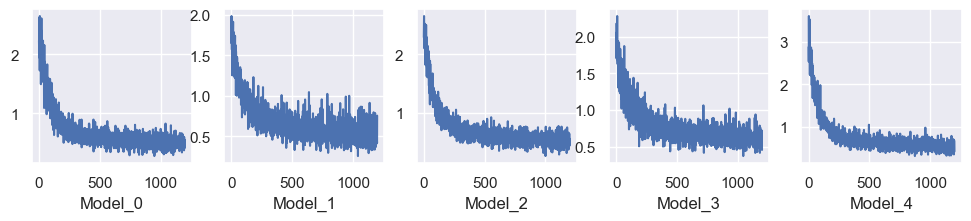

In [6]:
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 2))
for i in range(5):
    axs[i].plot(report['train_losses'][i])
    axs[i].set_xlabel(f'Model_{i}')

In [7]:
key = jax.random.PRNGKey(0)

val_probs = nn.activation.softmax(jnp.stack(report['val_logits'], axis=0), axis=-1)

# softmax
@jax.jit
def loss_alpha(alpha, probs, y, **kwargs):
    weights = nn.activation.softmax(alpha, axis=-1)[..., None, None]
    log_w_probs = jnp.log((probs * weights).sum(axis=0))
    return -jnp.take_along_axis(log_w_probs, y[..., None], axis=-1).mean()

# gumbel-softmax
@jax.jit
def loss_gumbel(alpha, probs, y, key, t=0.01):
    gumbels = -jnp.log(-jnp.log(jax.random.uniform(key, alpha.shape)))
    weights = nn.activation.softmax((alpha + gumbels) / t, axis=-1)[..., None, None]
    log_w_probs = jnp.log((probs * weights).sum(axis=0))
    return -jnp.take_along_axis(log_w_probs, y[..., None], axis=-1).mean()

def optimize_weights(loss_fn, key):
    alphas = jax.random.normal(key, (M,)) * 1e-3
    opt = optax.adam(1e-1)
    opt_state = opt.init(alphas)
    val_losses = []
    val_weights = []
    for _ in range(1000):
        crit = lambda a: loss_fn(a, val_probs, Y_val, key=key, t=0.1)
        grad_fn = jax.value_and_grad(crit)
        loss, grads = grad_fn(alphas)
        val_losses.append(loss)
        val_weights.append(nn.activation.softmax(alphas, axis=-1))
        upd, opt_state = opt.update(grads, opt_state)
        alphas = optax.apply_updates(alphas, upd)
        key, _ = jax.random.split(key)

    return val_losses, val_weights

def plot_nll(val_losses, label):
    plt.figure(figsize=(8, 2))
    plt.title(label)
    plt.xlabel('Iteration')
    plt.ylabel('Ensemble NLL')
    plt.plot(val_losses)
    plt.show()
    print('Min NLL', min(val_losses))
    
def plot_weights(alphas, label):
    plt.figure(figsize=(10, 3))
    plt.title(label)
    plt.xlabel('Iteration')
    plt.ylabel('softmax(alpha)')
    selected_ids = range(0, 1000, 100)
    x = [str(i) for i in selected_ids]
    bottom = np.zeros(len(selected_ids))
    for m in range(M):
        y = np.array([alphas[i][m] for i in selected_ids])
        plt.bar(x, y, bottom=bottom)
        bottom += y

In [8]:
val_losses, val_weights = optimize_weights(loss_alpha, jax.random.PRNGKey(0))

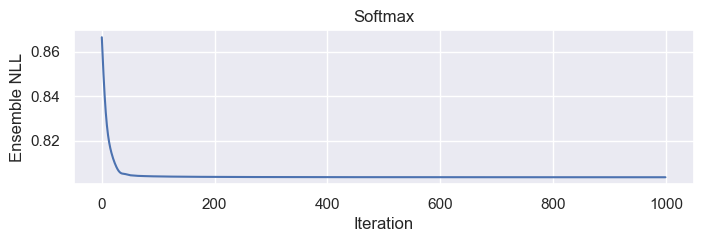

Min NLL 0.8035829


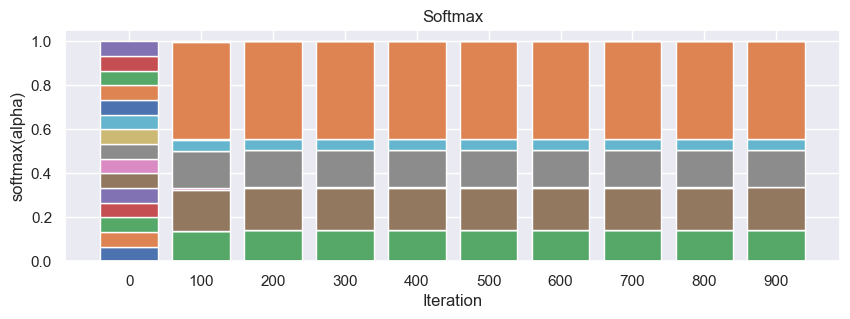

In [9]:
label = 'Softmax'
plot_nll(val_losses, label)
plot_weights(val_weights, label)

In [10]:
val_losses, val_weights = optimize_weights(loss_gumbel, jax.random.PRNGKey(0))

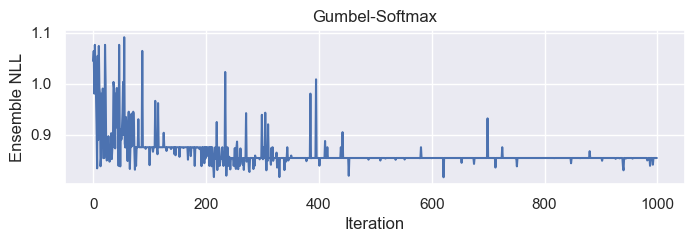

Min NLL 0.81651056


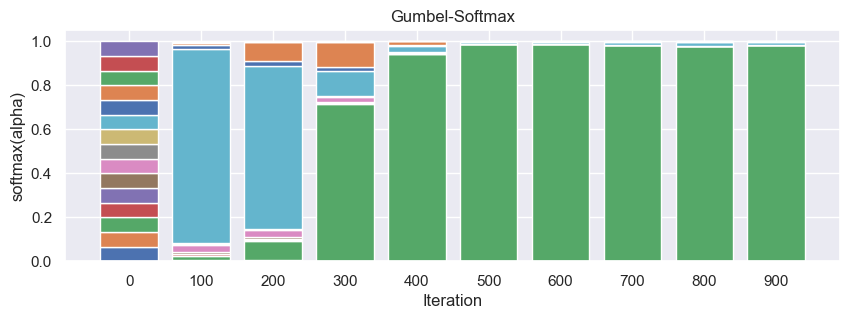

In [11]:
label = 'Gumbel-Softmax'
plot_nll(val_losses, label)
plot_weights(val_weights, label)

### Conclusion

We see that when using Gumbel-Softmax, the solution becomes degenerated. The solution corresponds
to the best performing base model.

At the same time, ordinary softnax does not guarantee sparcity, but this gives better validation perfomance than the performance of best base model.